# Visualization of ghg emission x words
Ref: https://github.com/Data-Science-Public-Policy/graspp_2025_spring/blob/main/notebooks/module_4/week_9/transformer_spacy_scrape.ipynb

In [24]:
import pandas as pd

In [25]:
ghg_df = pd.read_csv("../data/processed/edgar_ghg_emission_processed.csv",
                     index_col=None)
ghg_df = ghg_df.drop(columns=ghg_df.columns[[0]])
ghg_df.head()

,Country,Year,Emission (MtCO2eq/yr)
0,GLOBAL TOTAL,2014-01-01,48930.176837
1,GLOBAL TOTAL,2015-01-01,48808.767176
2,GLOBAL TOTAL,2016-01-01,49058.441256
3,GLOBAL TOTAL,2017-01-01,49878.733809
4,GLOBAL TOTAL,2018-01-01,51026.627449


# 2.1 Counting words

In [26]:
import pandas as pd
# IF previous 2.A doesn't work
file_name = "../data/processed/manifesto_us_japan.parquet"
df_all = pd.read_parquet(file_name)
df_all.reset_index().countryname.unique()

array(['United States', 'Japan'], dtype=object)

### 2.1.1 Create count function

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
# Count!
count_array = vectorizer.fit_transform(
                        df_all['text'] # INPUT THE TEXT COLUMN TO THE WORD COUNTER "vectorizer"
        ).toarray()

type(count_array) #Matrix with the counts but not yet a data frame

numpy.ndarray

### 2.1.2 Make the count function into a dataframe

In [28]:
df_wordcount = pd.DataFrame(
    count_array, # Data above will become the values of the dataframe
    columns=vectorizer.get_feature_names_out(), # Words will become the column names
    index = df_all.index # Index country date comes from the df_all dataframe
)
df_wordcount.head(2)

,00,000,000american,000フ,000万人,000万人を目指し,000円を目指します,01,052名減,057人分,...,ｔｉｓａ,ｔｐｐ,ｔｐｐへの参加に反対し,ｔｐｐイレブン,ｔｐｐ交渉に関する情報公開を強く要求します,ｔｐｐ参加による緩和,ｔｐｐ参加に反対し,ｔｐｐ参加反対,ｔｐｐ承認案,ｕｐｚ
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.1.3 Show most common words

In [29]:
df_wordcount.sum(axis='rows').sort_values(ascending=False).to_frame("most_common").head(10)

,most_common
the,47659
and,35841
of,28398
to,28365
in,15226
we,14088
for,10042
our,8927
that,8920
will,7048


## 2.2 Count n-grams (more than one word combinations)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
# Now we can get fancier with the count vectorizer by counting more than one word combinations and remove stop words
vectorizer = CountVectorizer(
    analyzer = 'word',          # Whether the feature should be made of word or character n-grams or a mixture of both.
    stop_words = 'english',     # Remove stop words. Can be a list of stop words or a string from {'english', 'spanish'}.
    lowercase = True,           # Convert text to lowercase.
    ngram_range = (3,3),

)
# Count!
count_array = vectorizer.fit_transform(df_all['text']).toarray()
df_wordcount = pd.DataFrame(
    count_array, # Data above will become the values of the dataframe
    columns=vectorizer.get_feature_names_out(), # Words will become the column names
    index = df_all.index # Index country date comes from the df_all dataframe
)
df_wordcount.sum(axis='rows').sort_values(ascending=False).to_frame("most_common").head(10)

,most_common
state local governments,95
democratic party committed,59
weapons mass destruction,57
today democratic party,50
world war ii,50
low income families,49
federal state local,47
democratic party believes,47
quality health care,46
covid 19 pandemic,46


<Axes: >

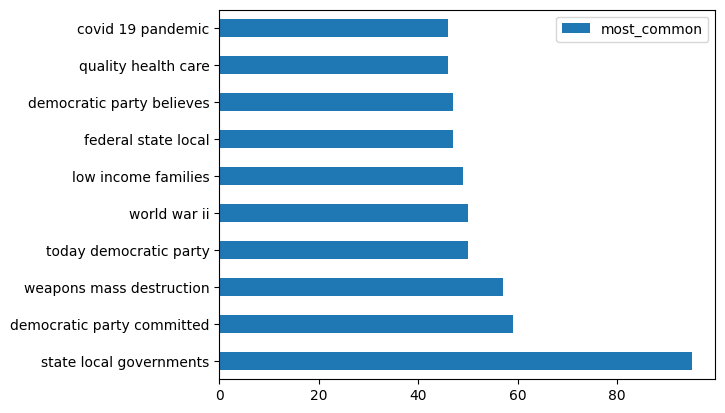

In [31]:
df_wordcount.sum(axis='rows').sort_values(ascending=False).to_frame("most_common").head(10).plot(kind = 'barh')

## 2.3 Visualizing word count in dataframe

In [32]:
vectorizer = CountVectorizer(
    analyzer = 'word',          # Whether the feature should be made of word or character n-grams or a mixture of both.
    stop_words = 'english',     # Remove stop words. Can be a list of stop words or a string from {'english', 'spanish'}.
    lowercase = True,           # Convert text to lowercase.
    ngram_range = (1,3),
    min_df = .1

)
counts = vectorizer.fit_transform(df_all['text']).toarray().sum(axis=0)
word_freq = dict(zip(vectorizer.get_feature_names_out(), counts))

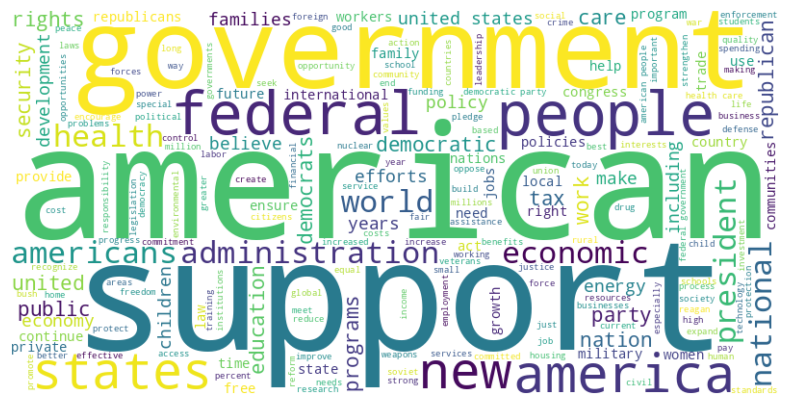

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 2.4 Make into a function

In [34]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_country_wordcloud(country_name, df, ax=None, save_path=None):
    country_df = df.query(f"countryname == '{country_name}'")
    vectorizer = CountVectorizer(
        analyzer='word',
        stop_words='english',
        lowercase=True,
        ngram_range=(1, 3),
        min_df=0.1
    )

    counts = vectorizer.fit_transform(country_df['text']).toarray().sum(axis=0)
    word_freq = dict(zip(vectorizer.get_feature_names_out(), counts))

    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(word_freq)

    if ax:
        ax.imshow(wordcloud)
        ax.axis('off')
        ax.set_title(f"Word Cloud for {country_name}", size=20)
    else:
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.title(f"Word Cloud for {country_name}", size=20)

    if save_path:
        plt.savefig(save_path)

### 2.4.1 One example

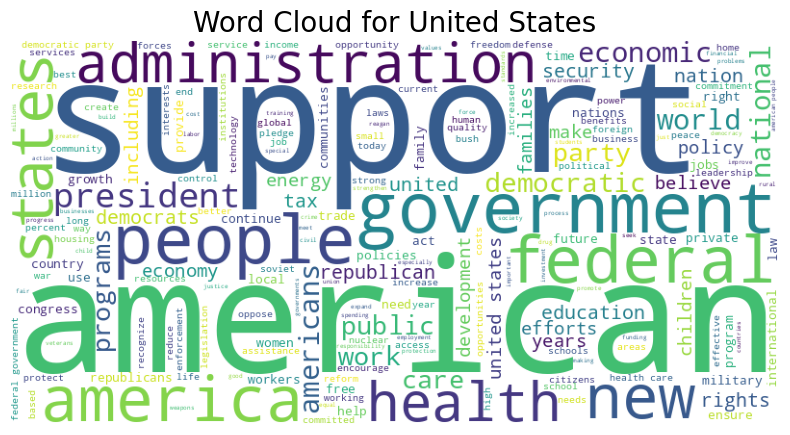

In [35]:
#fig, axes = plt.subplots(figsize=(12, 10))

generate_country_wordcloud(
    country_name = 'United States',
    df = df_all,
    #ax = axes
)

### 2.4.2 Multiple

AttributeError: 'Axes' object has no attribute 'flatten'

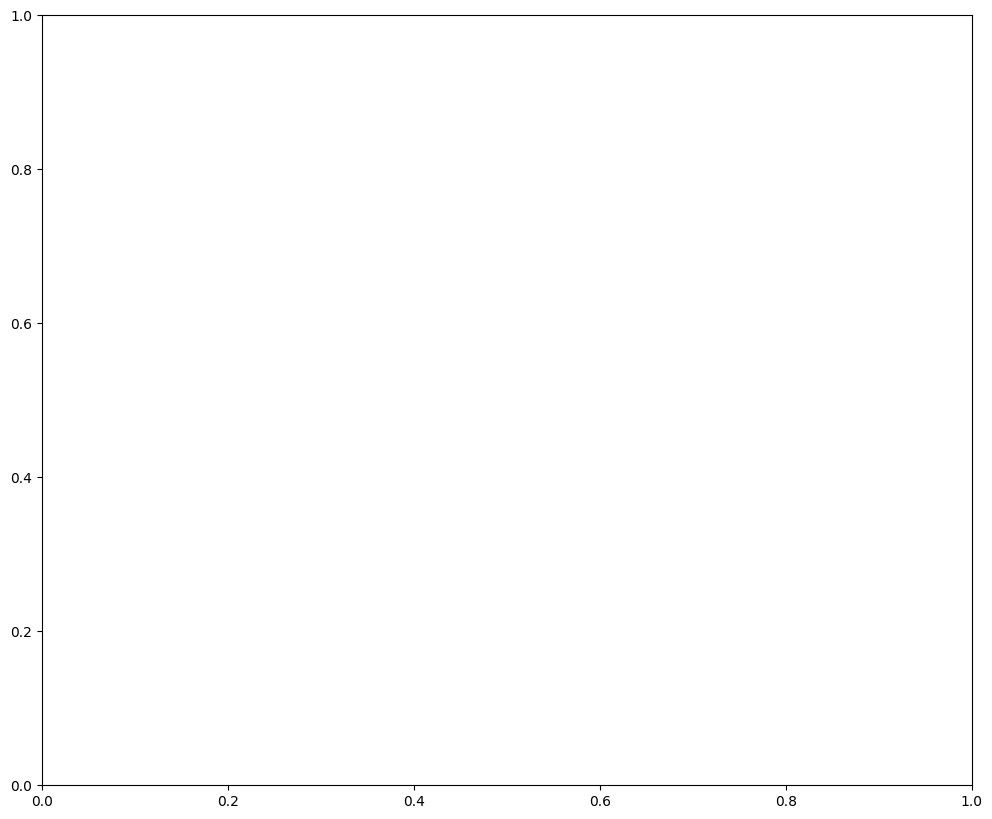

In [36]:
countries_to_plot = ['United States'] # A sample of 4 countries for a 2x2 grid

# 3. Create a 2x2 subplot figure
fig, axes = plt.subplots(1, 1, figsize=(12, 10))
axes = axes.flatten() # Flatten the 2x2 array of axes to easily iterate through them
for i, country in enumerate(countries_to_plot):
    generate_country_wordcloud(
        country, df_all, axes[i] # Run function for all
                              )
plt.tight_layout()


## 2.5 Count words across time

### 2.5.1 Count by country

In [ ]:
vocab_list = ['ghg', 'greenhouse', 'net-zero', 'carbon']
vectorizer = CountVectorizer(
    stop_words = 'english',     # Remove stop words. Can be a list of stop words or a string from {'english', 'spanish'}.
    lowercase = True,           # Convert text to lowercase.
    ngram_range = (1,1),
    vocabulary = vocab_list

)
counts = vectorizer.fit_transform(df_all['text']).toarray().sum(axis=0)
word_freq = dict(zip(vectorizer.get_feature_names_out(), counts))
word_freq

{'ghg': 0, 'greenhouse': 23, 'net-zero': 0, 'carbon': 42}

### 2.5.2 Count by year and date

In [ ]:
# add year column
df_all = df_all.reset_index().assign(year = lambda column: column['date'].dt.year)
df_all.head(2)

,index,countryname,date,party,partyname,keys,manifesto_id,text,year
0,0,United States,1960-11-01,61320,Democratic Party,61320_196011,61320_196011,"In 1796, in America's first contested national...",1960
1,1,United States,1960-11-01,61620,Republican Party,61620_196011,61620_196011,PREAMBLE The United States is living in an age...,1960


In [ ]:
word_freq_by_country = {}
for country_name, country_df in df_all.groupby(['countryname', 'year']):
    vectorizer = CountVectorizer(
        stop_words='english',
        lowercase=True,
        ngram_range=(1, 1),
        vocabulary=vocab_list
    )
    counts = vectorizer.fit_transform(country_df['text']).toarray().sum(axis=0)
    word_freq_by_country[country_name] = dict(zip(vectorizer.get_feature_names_out(), counts))
df_timeseries = pd.DataFrame(word_freq_by_country).transpose()
df_timeseries.head(2)

ghg  greenhouse  net-zero  carbon
Japan 2014    0           0         0       0
      2017    0           0         0       0

#### Convert to Long

In [ ]:
df_long = df_timeseries.stack().to_frame('count').reset_index()
df_long.head(3)

,level_0,level_1,level_2,count
0,Japan,2014,ghg,0
1,Japan,2014,greenhouse,0
2,Japan,2014,net-zero,0


In [ ]:
df_long = df_long.rename({"level_0": 'country', 'level_1':'year', 'level_2': 'vocab'}, axis='columns')
df_long.head(2)

,country,year,vocab,count
0,Japan,2014,ghg,0
1,Japan,2014,greenhouse,0


#### Plot

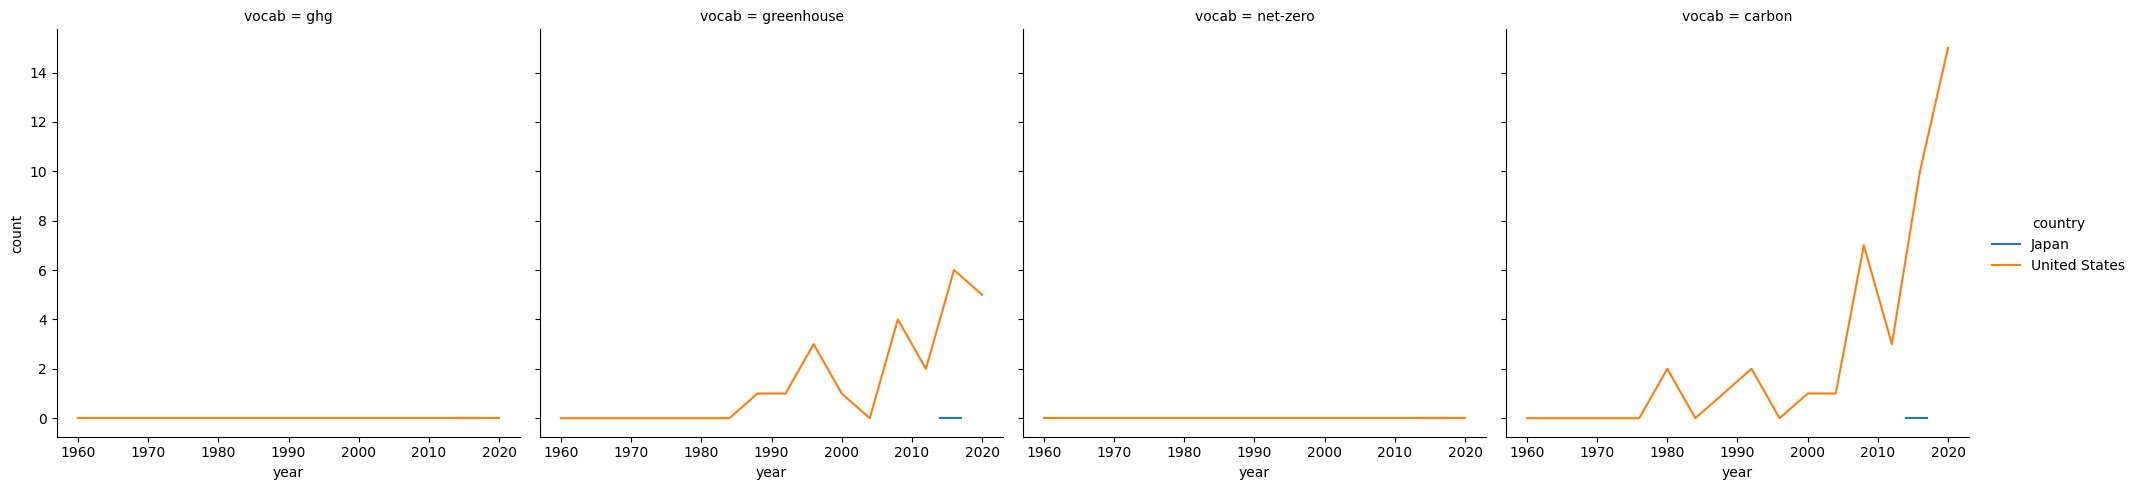

In [43]:
import seaborn as sns
sns.relplot(
    data=df_long, x="year", y="count", hue="country", col="vocab", kind="line"
)

# 4. Visualization of GHG x Word count

## 4.1 Use df_long and ghg data

In [44]:
df_long_viz = df_long.pivot(
    index = ['country', 'year'],
    columns = 'vocab',
    values = 'count')

df_long_viz.head(2)

vocab         carbon  ghg  greenhouse  net-zero
country year                                   
Japan   2014       0    0           0         0
        2017       0    0           0         0

In [45]:
ghg_df_viz = ghg_df.copy()
ghg_df_viz["Year"] = ghg_df_viz["Year"].str.slice(start=0, stop=4).astype("int32")

In [46]:
ghg_df

,Country,Year,Emission (MtCO2eq/yr)
0,GLOBAL TOTAL,2014-01-01,48930.176837
1,GLOBAL TOTAL,2015-01-01,48808.767176
2,GLOBAL TOTAL,2016-01-01,49058.441256
3,GLOBAL TOTAL,2017-01-01,49878.733809
4,GLOBAL TOTAL,2018-01-01,51026.627449
...,...,...,...
115,Canada,2019-01-01,788.007679
116,Canada,2020-01-01,711.931324
117,Canada,2021-01-01,728.267914
118,Canada,2022-01-01,745.245079


In [68]:
df_viz = df_long_viz.merge(
    ghg_df_viz, left_on=["country", "year"],
    right_on=["Country", "Year"])

df_viz = df_viz.melt(id_vars=['Year', 'Country'], var_name=
                            'Words', value_name='Value')
df_viz.head(2)

,Year,Country,Words,Value
0,2014,Japan,carbon,0.0
1,2017,Japan,carbon,0.0
